# Ejercicio

EJERCICIO PARTE PRÁCTICA SERIES TEMPORALES

En este ejercicio los alumnos deben demostrar que son capaces de utilizar el programa Python de forma adecuada para trabajar con series temporales.
Para ello se les facilitan unos datos sobre una serie temporal, a su vez se permite que usen apuntes, los códigos compartidos durante las sesiones, así como ayuda complementaria que puedan encontrar en internet. También esta permitido trabajar en grupos de hasta 3 personas.
Las tareas que deben realizar son:
- Determinar si es una serie estacionaria o no, utilizando diferentes procedimientos. En este punto es necesario realizar análisis gráficos y diferentes test.
- Determinar si es una serie estacional y en su caso cual es la frecuencia con la que se da la estacionalidad.
- Determinar cuál es modelo óptimo para estimar. Para ello se puede utilizar el autoarima u otro tipo de análisis.
- Comprobar que el modelo estimado es correcto. Para este punto es necesario tanto analizar las predicciones como los residuos

Los alumnos deberán subir el fichero de Python utilizado para la realización de los cálculos.  En dicho fichero se pueden añadir los comentarios que se desee para facilitar la comprensión del Código y analizar los resultados obtenidos.

La fecha límite es el día 22 de febrero.

# Librerias

In [50]:
import pandas as pd
import os
import pmdarima
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.stattools import adfuller,kpss
from arch.unitroot import PhillipsPerron as PP,DFGLS

# Modelizacion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


In [51]:
# Cargamos los datos
datos = pd.read_csv("DatosEjercicio.csv")


In [52]:
datos.head()

,Month,Value
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [53]:
datos.size

952

In [54]:


# Pasamos la fecha a formato fecha
datos["Month"] = pd.to_datetime(datos["Month"], format="%Y-%m")

# Pasamos la fecha al indice
datos.index = datos["Month"]
del (datos["Month"])


In [55]:
datos.head()

,Value
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


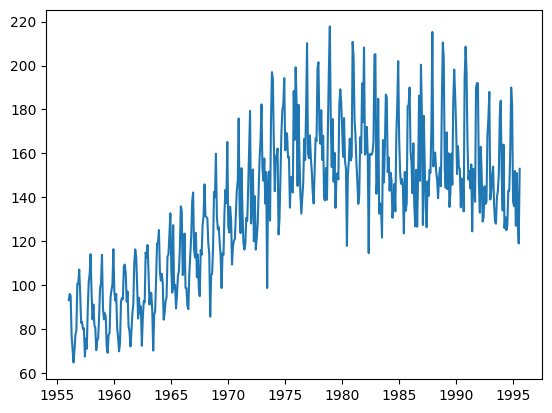

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(datos)

## Procedemos a calcular el numero de diferencias


In [57]:
# Respecto a la observacion anterior
pmdarima.arima.ndiffs(datos)

1

In [58]:
# Estacionalmente con estacionalidad anual.
pmdarima.arima.nsdiffs(datos, m = 12)

0

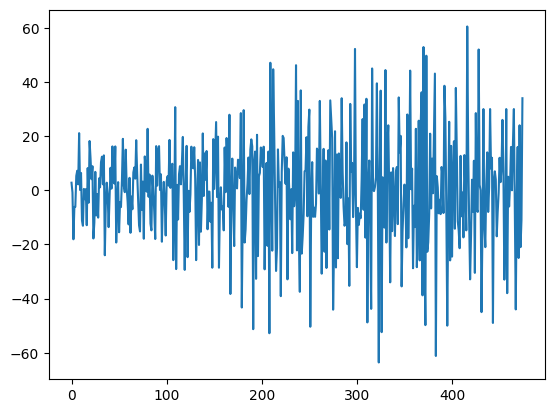

In [59]:
datosdiff = pmdarima.utils.diff(datos,lag = 1, differences= 1)
# Graficamos los datos diferenciados.
plt.plot(datosdiff)
# Se soluciona el problema de la media (se vuelve mas constante)
# Pero no el de la varianza, aumenta con el tiempo.

In [60]:
pmdarima.arima.ndiffs(datosdiff)

0

## Trasformamos a log

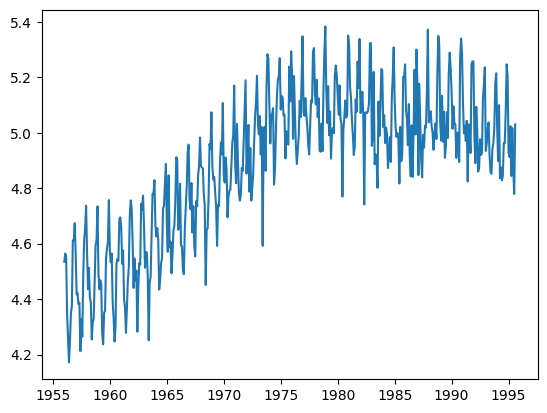

In [61]:
datos["Value"] = datos["Value"].astype(float)
Log_Datos = pd.DataFrame(np.log(datos["Value"]))

# Graficamos.
plt.plot(Log_Datos)

In [62]:
pmdarima.arima.ndiffs(Log_Datos)

1

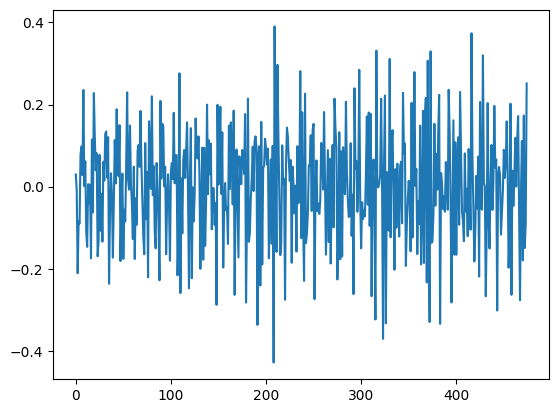

In [63]:
Log_Datos_Dif = pd.DataFrame(pmdarima.utils.diff(Log_Datos,lag = 1, differences= 1))

# Graficamos
plt.plot(Log_Datos_Dif)

In [64]:
pmdarima.arima.ndiffs(Log_Datos_Dif)

0

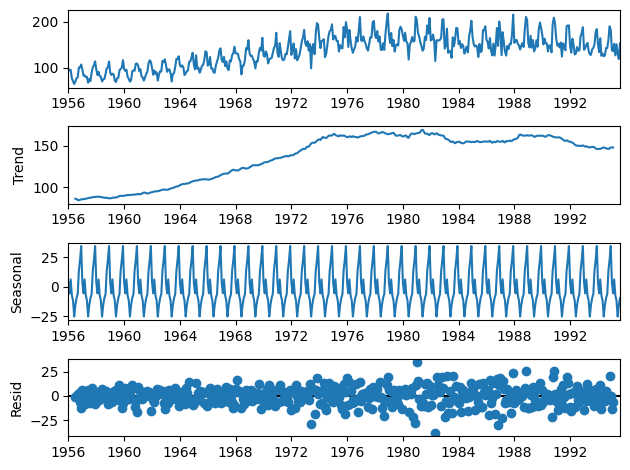

In [65]:
SerieDescompuesta = seasonal_decompose(datos, model='additive')
SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False);

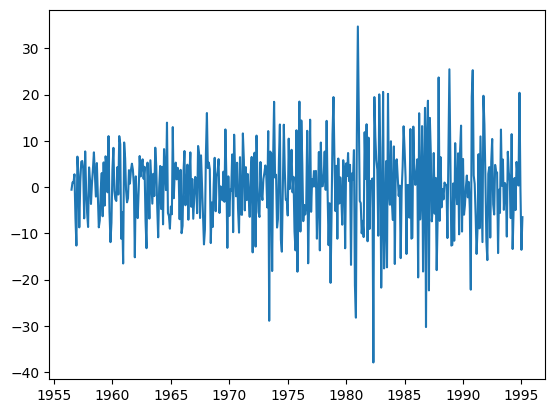

In [66]:
plt.plot(SerieDescompuesta.resid)

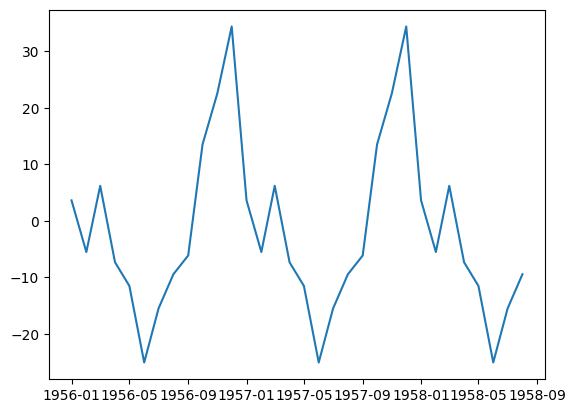

In [170]:
plt.plot(SerieDescompuesta.seasonal[:32])

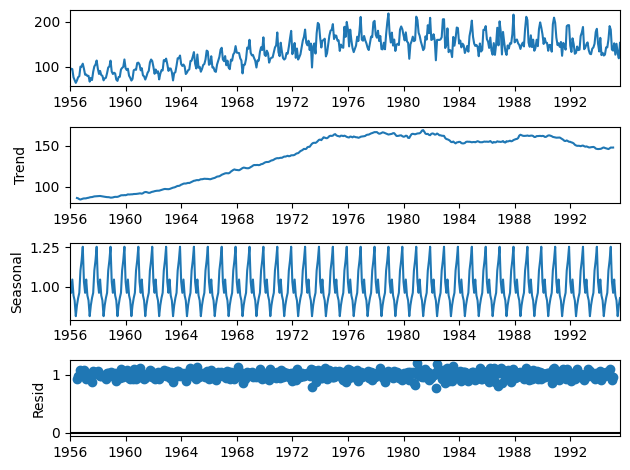

In [67]:
# La decomponemos de forma multiplicativa
# De manera aditiva
SerieDescompuestaMult = seasonal_decompose(datos, model='multiplicative')

# La graficamos.
SerieDescompuestaMult.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False);

## Suavizado


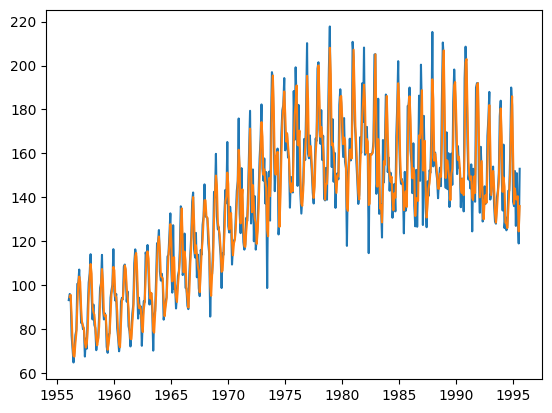

In [31]:
# Suavizado basado en medias moviles
datos['mov_avg'] = datos['Value'].rolling(2).mean()
# Graficamos esta nueva serie
plt.plot(datos)
del (datos['mov_avg'])

## Exponential Smoothing holtwinters

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


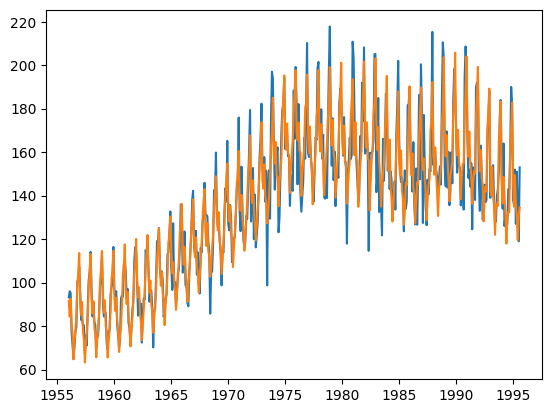

In [32]:

model = HWES(datos, seasonal_periods=12, trend='add', seasonal='add').fit()

# Graficamos el suavizado expoencial
datos["HWES"] = model.fittedvalues
plt.plot(datos)
# La eliminamos 
del (datos["HWES"])

# Estariedad de la serie

## Estariedad de la serie sin diferencias


En esta serie de analisis vemos como con una significancia del 95%:

|  Test  | p_valor |    Resultado     |
| ------ | ------- | ---------------- |
|  ADF   |  0.177  |  No Estacionaria |
|  KPSS  |  0.010  |  No Estacionaria |
|   PP   |  0.000  |   Estacionaria   |
|  ERS   |  0.834  |  No Estacionaria |

Salvo el test de Phillips Perron el resto resultan en que la serie es no estacionaria. Por lo que entendemos que la series es no estacionaria. 

### ADF
Planteamos las hipotesis
- $H_0$: Serie NO estacionaria, tiene una raiz unitaria
- $H_1$: Serie estacionaria

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [78]:
ADF = adfuller(datos["Value"])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -2.282661
p-value: 0.177621


**Resultado**: No tenemos suficiente evidencia estadistica para rechazar $H_0$, suponemos que es cierta por lo que la serie *no es estacionaria*

### KPSS
Este contraste es al contrario suponemos que la series es estacionaria.
- $H_0$: Serie estacionaria 
- $H_1$: Serie NO estacionaria, tiene una raiz unitaria

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [79]:
KPSS = kpss(datos["Value"])
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 2.965464
p-value: 0.010000


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


**Resultado**: Como el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%. Por tanto, *Serie No estacionaria*

### PP
- $H_0$: La serie contiene una raiz unitaria.
- $H_1$: La serie es *levemente* estacionaria.

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [80]:
pp_results = PP(datos["Value"])
pp_results

Test Statistic,-7.491
P-value,0.000
Lags,18


**Resultado**: Como el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%. Pero en este contraste si que vemos que es *levemente* estacionaria. 

### ERS

Planteamos las hipotesis
- $H_0$: Serie NO estacionaria, tiene una raiz unitaria
- $H_1$: Serie estacionaria

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [81]:
ERS = DFGLS(datos["Value"])
ERS

Test Statistic,0.486
P-value,0.834
Lags,17


**Resultado**: Como el $p_{valor} > 0.05 $, no tenemos suficiente evidencia estadistica para rechazar H0 -> Serie no estacionaria

## Estariedad de la serie con diferencias

En esta serie de analisis vemos como con una significancia del 95%:

|  Test  | p_valor |    Resultado     |
| ------ | ------- | ---------------- |
|  ADF   |  0.000  |   Estacionaria   |
|  KPSS  |  0.100  |   Estacionaria   |
|   PP   |  0.000  |   Estacionaria   |
|  ERS   |  0.521  |  No Estacionaria |

Por el contario los test evaluados en este caso nos sale que tres son estacionarias. Por lo que podemos concluir que tomando primeras diferencias las serie obtenida es muy parecida a una serie estacionaria.

### ADF
Planteamos las hipotesis
- $H_0$: Serie NO estacionaria, tiene una raiz unitaria
- $H_1$: Serie estacionaria

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [82]:
ADF = adfuller(Log_Datos_Dif[0])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -4.869646
p-value: 0.000040


**Resultado**: Como el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%. *Serie estacionaria*

### KPSS
Este contraste es al contrario suponemos que la series es estacionaria.
- $H_0$: Serie estacionaria 
- $H_1$: Serie NO estacionaria, tiene una raiz unitaria

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [83]:
KPSS = kpss(Log_Datos_Dif[0])
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 0.009148
p-value: 0.100000


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


**Resultado**: Como el $p_{valor}* > 0.05 $ NO rechazamos $H_0$ con un nivel de significancia del 95%. *Serie estacionaria*

$*$ Según el error el $p_{valor}$ es mayor del que se ha obtenido por tanto no nos preocupamos

### PP
- $H_0$: La serie contiene una raiz unitaria.
- $H_1$: La serie es *levemente* estacionaria.

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [84]:
pp_results = PP(Log_Datos_Dif[0])
pp_results

Test Statistic,-40.455
P-value,0.000
Lags,18


**Resultado**: Como el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%. Pero en este contraste si que vemos que es *levemente* estacionaria. 

### ERS

Planteamos las hipotesis
- $H_0$: Serie NO estacionaria, tiene una raiz unitaria
- $H_1$: Serie estacionaria

Si el $p_{valor} < 0.05 $ rechazamos $H_0$ con un nivel de significancia del 95%

In [85]:
ERS = DFGLS(Log_Datos_Dif[0])
ERS

Test Statistic,-0.450
P-value,0.521
Lags,18


**Resultado**: Como el $p_{valor}* > 0.05 $ NO rechazamos $H_0$ con un nivel de significancia del 95%. *Serie NO estacionaria*

# Modelización

## Correlogramas


Estamos viendo las relaciones entre las observaciones $ y_t  \to  y_{t-1}, y_{t-2}, \dots $ 
Si existe alguna relación periodica o no en los correlogramas. Pero cuidado porque a veces las relaciones que se ven no tienen sentido de negocio. Por ejemplo en el parcial se esta viendo una relacion cada 6 meses pero no tiene sentido de negocio,

Para le modelo queremos predecir los datos, por eso metemos el log sin la diff

### Correlograma 

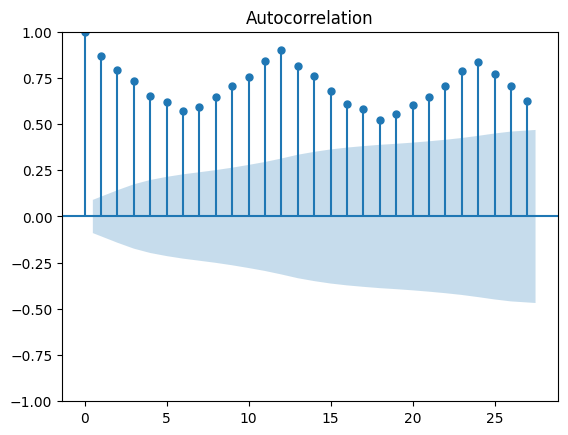

In [87]:
plot_acf(Log_Datos);

### Correlograma parcial

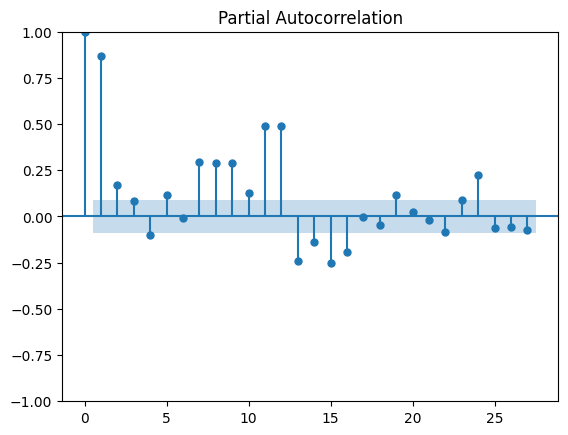

In [88]:
plot_pacf(Log_Datos);

## Dividimos los datos en train y test
Para le modelo queremos predecir los datos, por eso metemos el log sin la diff

In [161]:
def manual_train_test_split(df,perc=0.8):
    print(f"Init size: {df.size}")
    n = int(df.size*perc)
    train = df.iloc[:int(df.size*perc)]
    test = df.iloc[int(df.size*perc):]
    print(f"Nº datos de entrenamiento: {train.size}, nº datos de test: {test.size}, and total size: {train.size+test.size}")
    return train, test

In [162]:
train, test = manual_train_test_split(Log_Datos)

Init size: 476
Nº datos de entrenamiento: 380, nº datos de test: 96, and total size: 476


## Entrenamos 

In [163]:
model = sm.tsa.statespace.SARIMAX(train.iloc[:,0], order=(2,1,2), seasonal_order=(1,0,1,12))
# ,enforce_stationarity=False,mle_regression=False)

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [164]:
ArimaModel = model.fit()
ArimaModel.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.73606D-01    |proj g|=  2.38909D+00

At iterate    5    f= -9.13053D-01    |proj g|=  3.73518D+00

At iterate   10    f= -1.03319D+00    |proj g|=  5.44945D-01

At iterate   15    f= -1.11039D+00    |proj g|=  9.93182D-01

At iterate   20    f= -1.12219D+00    |proj g|=  1.55206D-01

At iterate   25    f= -1.15122D+00    |proj g|=  5.04395D-02

At iterate   30    f= -1.15466D+00    |proj g|=  2.35360D-02

At iterate   35    f= -1.18983D+00    |proj g|=  8.69392D-02

At iterate   40    f= -1.19530D+00    |proj g|=  6.02053D-02

At iterate   45    f= -1.19597D+00    |proj g|=  2.70751D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Value   No. Observations:                  380
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 454.468
Date:                              Sun, 05 Feb 2023   AIC                           -894.937
Time:                                      10:34:52   BIC                           -867.374
Sample:                                  01-01-1956   HQIC                          -883.999
                                       - 08-01-1987                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1374      0.051    -22.414      0.000      -1.237      -1.038
ar.L2         -0.1727      0.050     -3.486      0.000      -0.270      -0.076
ma.L1          0.1019      0.033      3.117      0.002       0.038       0.166
ma.L2         -0.8760      0.035    -25.359      0.000      -0.944      -0.808
ar.S.L12       0.9963      0.002    487.020      0.000       0.992       1.000
ma.S.L12      -0.8210      0.038    -21.357      0.000      -0.896      -0.746
sigma2         0.0049      0.000     16.516      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                40.61
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

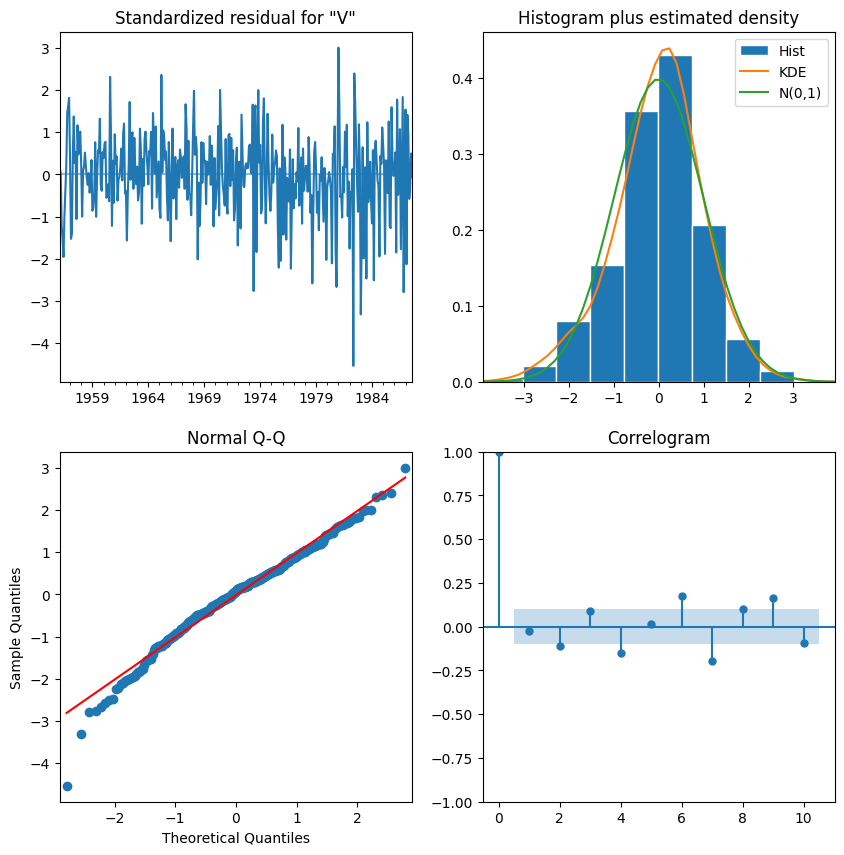

In [165]:
fig =plt.figure(figsize=(10, 10))
ArimaModel.plot_diagnostics(fig=fig);

In [166]:
test["Predicciones"] = ArimaModel.forecast(len(test))

/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_43425/2170066692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel.forecast(len(test))


/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_43425/3375441840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["actual_value"]  = np.exp(test["Value"])
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_43425/3375441840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["actual_forecast"]  = np.exp(test["Predicciones"])


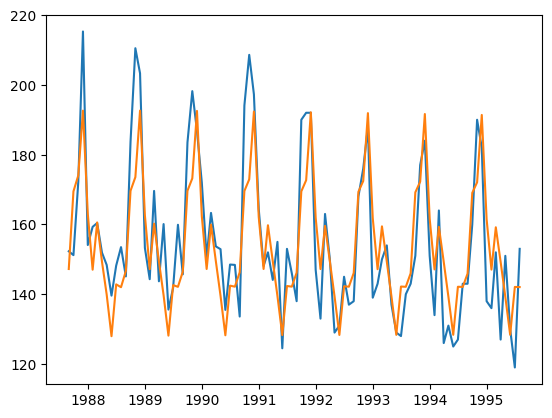

In [167]:
test["actual_value"]  = np.exp(test["Value"])
test["actual_forecast"]  = np.exp(test["Predicciones"])
plt.plot(test[["actual_value","actual_forecast"]])

## AUTOARIMA

/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:14: SettingWithCopyWarning: 
A value is t

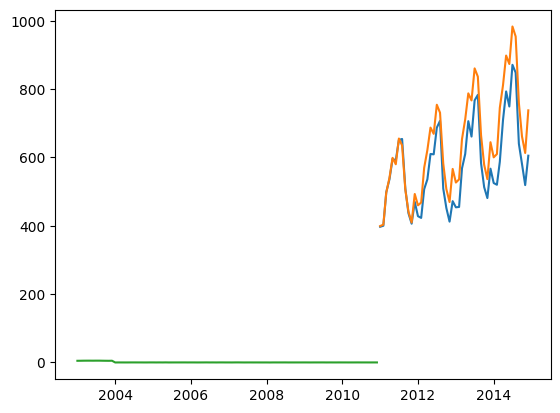

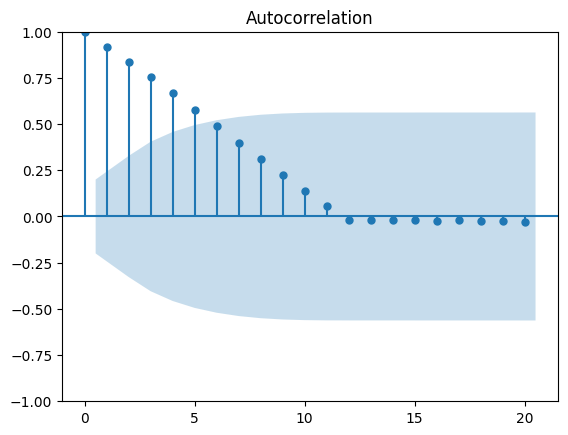

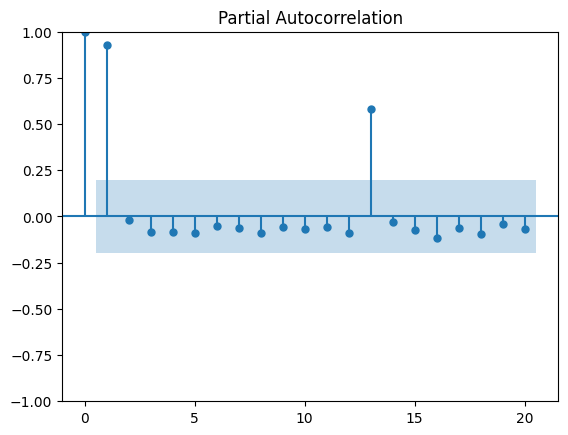

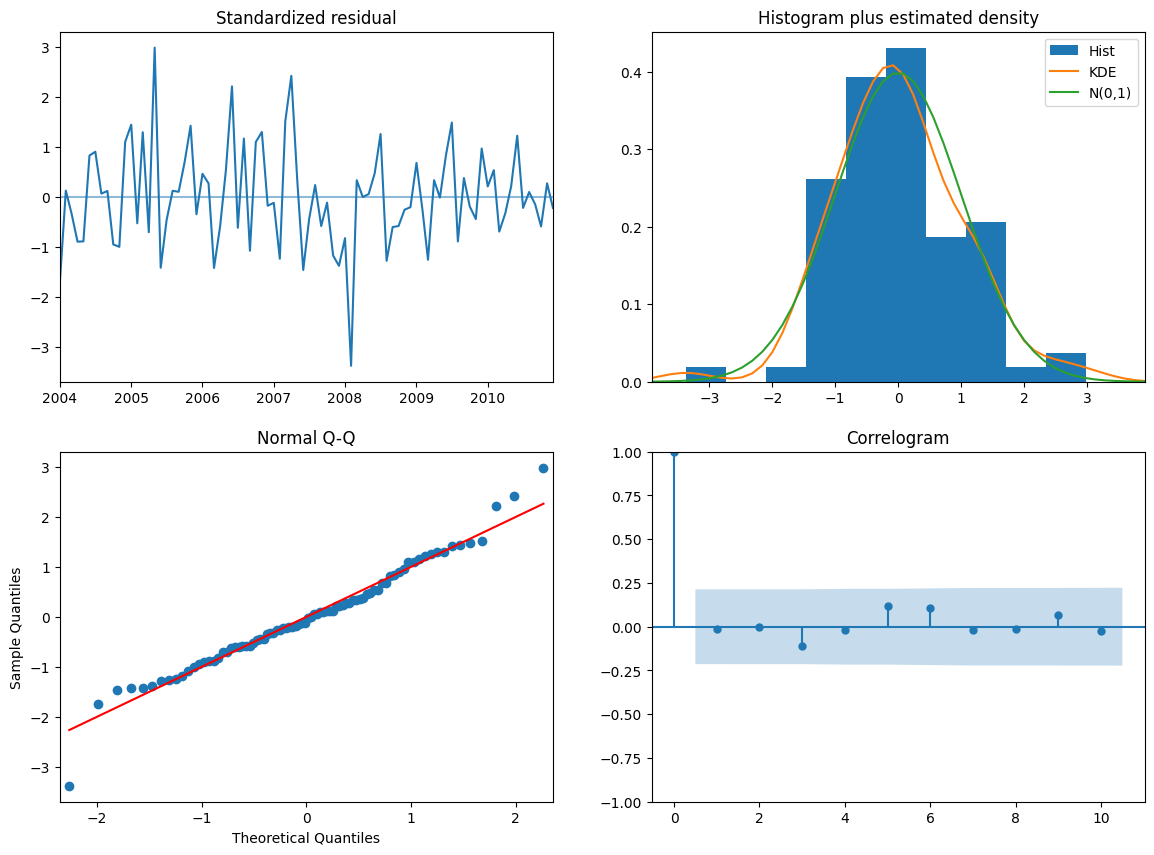

In [141]:

train = Log_Datos.loc[:"2010-12-01 00:00:00"]
test = Log_Datos["2011-01-01 00:00:00":]
# Pasamos a utilizar el AutoArima  (No lo hace bien)
ArimaModel = pmdarima.auto_arima(train, error_action='ignore', seasonal=True, m=12,start_p=1,start_d=1,start_q=1,max_D=1)

ArimaModel.summary()

# Sacamos las predicciones del modelo.
test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))


# Estas predicciones son logaritmos por lo que hay que invertir el proceso
test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
test["Predicciones"]  = np.exp(test["Predicciones"])

# Graficamos los datos de test.
plt.plot(test)


# Analizamos los residuos del modelo.
plt.plot(ArimaModel.resid())

# Comprobamos que los residuos iniciales son altos

# Analizamos el correlograma y el correlograma parcial de los errores
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ArimaModel.resid())
plot_pacf(ArimaModel.resid())

ArimaModel.plot_diagnostics(figsize = (14,10));


In [142]:
ArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 153.002
Date:                            Fri, 03 Feb 2023   AIC                           -294.003
Time:                                    18:59:59   BIC                           -279.419
Sample:                                01-01-2003   HQIC                          -288.140
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0561      0.029      1.959      0.050   -2.04e-05       0.112
ar.L1          0.5536      0.116      4.778      0.000       0.327       0.781
ar.L2          0.2133      0.112      1.911      0.056      -0.005       0.432
ar.S.L12      -0.5638      0.134     -4.195      0.000      -0.827      -0.300
ar.S.L24      -0.2363      0.158     -1.494      0.135      -0.546       0.074
sigma2         0.0014      0.000      6.173      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.91   Prob(JB):                         0.10
Heteroskedasticity (H):               0.36   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""